In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
from scipy import sparse 
import itertools

import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.decomposition import PCA
from umap import UMAP

from py_pcha import PCHA

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu



In [2]:
def plot_pcs(res, npc, hue, palette=None):
    fig, axs = plt.subplots(npc-1,npc-1,figsize=(6*(npc-1),5*(npc-1)))
    for i, j in itertools.combinations(range(npc), 2):
        legend = False
        if (i,j) == (0,1): legend=True

        x, y = f"PC{j+1}", f"PC{i+1}"
        ax = axs[i,j-1]
        
        if palette is not None:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            hue_order=list(palette.keys()),
                            palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        else:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            # hue_order=list(palette.keys()),
                            # palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        sns.despine(ax=ax)
    axs[0,0].legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')

    for i, j in itertools.product(range(npc-1), range(npc-1)):
        if j<i:
            ax = axs[i,j]
            ax.axis('off')

    plt.show()

In [3]:
outdir     = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results"
outdir_fig = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/figures"

In [4]:
adata_raw = anndata.read("../../data/fly_t4t5/GSM3592260_T4T5_48.h5ad")
adata_raw.obs['n_counts'] = adata_raw.X.sum(axis=1)
adata_raw.obs

# adata_raw = adata_raw[adata_raw.obs['Subclass']=='L2/3']
# adata_raw = adata_raw[adata_raw.obs['cond'].isin(['P28NR','P28DR'])]
# counts = adata_raw.X
# allgenes = adata_raw.var.index.values
# adata_raw

,barcode,cluster,n_counts
0,AAACCTGAGAATAGGG,T4a,3980
1,AAACCTGAGCCACTAT,T4d,4178
2,AAACCTGAGCTTTGGT,T4d,3610
3,AAACCTGAGGGCATGT,T4d,4125
4,AAACCTGCACCGTTGG,T5c,4760
...,...,...,...
3889,TTTGTCAGTAAAGGAG,T4b,3307
3890,TTTGTCAGTCGAACAG,T4c,5287
3891,TTTGTCAGTTTGTTGG,T4b,3823
3892,TTTGTCATCAACGGGA,T4b,5209


In [5]:
adata_raw.obs['cluster'].value_counts()

T4b         521
T4a         474
T4d         454
T5d         439
T5b         435
T5a         432
T5c         407
T4c         398
filtered    334
Name: cluster, dtype: int64

In [6]:
adata_raw.obs.groupby('cluster').mean()

/tmp/ipykernel_18382/1777350970.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  adata_raw.obs.groupby('cluster').mean()


,n_counts
cluster,
T4a,4660.118143
T4b,4465.669866
T4c,4296.869347
T4d,4273.359031
T5a,4597.805556
T5b,4519.179310
T5c,4246.985258
T5d,4264.927107
filtered,5457.532934


In [7]:
adata_raw = adata_raw[adata_raw.obs['cluster']!='filtered']
adata_raw

View of AnnData object with n_obs × n_vars = 3560 × 17492
    obs: 'barcode', 'cluster', 'n_counts'

In [8]:
# conds = adata_raw.obs['cond'].values
# types = adata_raw.obs['Type'].values
# newtypes = adata_raw.obs['newtype'].values
# samps = adata_raw.obs['sample'].values

In [9]:
# filter genes
cond = np.ravel((adata_raw.X>0).sum(axis=0)) > 10 # expressed in more than 10 cells
adata_sub = adata_raw[:,cond]
print(adata_sub.shape)

# counts
x = adata_sub.X
cov = adata_sub.obs['n_counts'].values
genes = adata_sub.var.index.values

# CP10k
xn = (sparse.diags(1/cov).dot(x))*1e4

# log10(CP10k+1)
xln = xn.copy()
xln.data = np.log10(xln.data+1)

adata_sub.layers['norm'] = xn
adata_sub.layers['lognorm'] = xln

(3560, 7225)


In [10]:
# select HVGs with mean and var
nbin = 20
qth = 0.3

# mean
gm = np.ravel(xn.mean(axis=0))

# var
tmp = xn.copy()
tmp.data = np.power(tmp.data, 2)
gv = np.ravel(tmp.mean(axis=0))-gm**2

# cut 
lbl = pd.qcut(gm, nbin, labels=np.arange(nbin))

# organize
gres = pd.DataFrame()
gres['name'] = genes
gres['lbl'] = lbl
gres['mean'] = gm
gres['var'] = gv
gres['ratio']= gv/gm

# select
gres_sel = gres.groupby('lbl')['ratio'].nlargest(int(qth*(len(gm)/nbin))) #.reset_index()
gsel_idx = np.sort(gres_sel.index.get_level_values(1).values)
assert np.all(gsel_idx != -1)

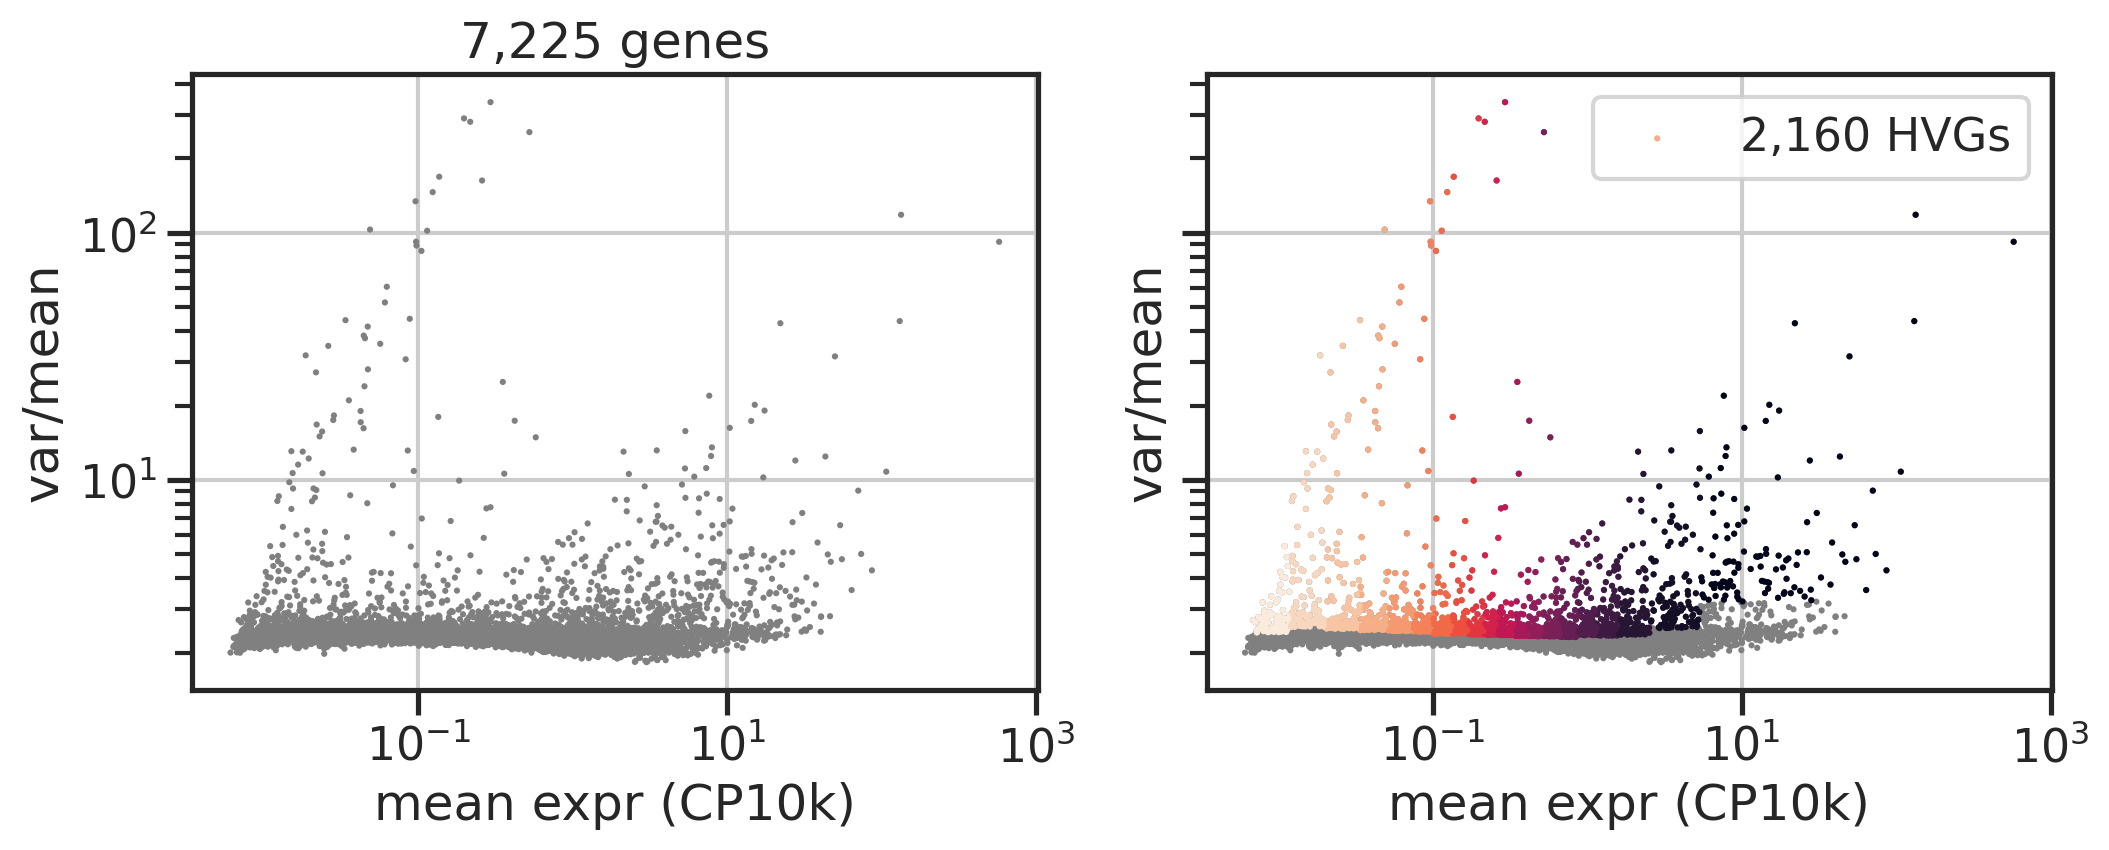

In [11]:
fig, axs = plt.subplots(1,2, figsize=(6*2,4), sharex=True, sharey=True)
ax = axs[0]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.set_title(f'{len(gm):,} genes')

ax = axs[1]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.scatter(gm[gsel_idx], (gv/gm)[gsel_idx], c=lbl[gsel_idx], s=5, edgecolor='none', cmap='rocket_r', label=f'{len(gsel_idx):,} HVGs')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.legend(bbox_to_anchor=(1,1))

plt.show()

In [12]:
adata = adata_sub[:,gsel_idx]
genes_sel = adata.var.index.values
adata

View of AnnData object with n_obs × n_vars = 3560 × 2160
    obs: 'barcode', 'cluster', 'n_counts'
    layers: 'norm', 'lognorm'

In [13]:
def norm_pca(adata, return_pcs=False):
    
    np.random.seed(0)
    pca = PCA(n_components=50)
    
    # zlognorm = zscore(np.array(adata.layers['lognorm'].todense()), axis=0)
    # zlognorm = np.nan_to_num(zlognorm, 0)
    # pcs = pca.fit_transform(zlognorm)
    
    lognorm = np.array(adata.layers['lognorm'].todense())
    lognorm = np.nan_to_num(lognorm, 0)
    pcs = pca.fit_transform(lognorm)
    
    if return_pcs:
        return pca, pcs
    else:
        return pca

In [14]:
pca, pcs = norm_pca(adata, return_pcs=True)

In [15]:
df = adata.obs.join(pd.DataFrame(pcs, index=adata.obs.index, columns=np.char.add("PC", (1+np.arange(pcs.shape[1])).astype(str))))
df

,barcode,cluster,n_counts,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,AAACCTGAGAATAGGG,T4a,3980,-2.677098,-2.098599,-0.443021,0.448579,-0.586281,-1.099478,-0.423311,...,0.304172,-0.525754,0.459913,0.471196,0.162595,0.038408,-0.619565,-0.299996,0.194714,-1.072067
1,AAACCTGAGCCACTAT,T4d,4178,2.822900,-2.034204,0.434094,-0.519621,0.058206,0.431582,-0.725042,...,-0.260728,0.406934,0.125453,-0.129984,-0.370725,-0.237051,0.475769,-0.273224,0.184880,-0.149224
2,AAACCTGAGCTTTGGT,T4d,3610,1.995152,-1.769858,0.767220,0.701594,0.158015,1.091675,-0.895007,...,0.245318,0.740370,-0.482752,-0.260431,-0.525093,-0.566876,0.147264,0.306877,-0.096169,0.442924
3,AAACCTGAGGGCATGT,T4d,4125,2.478060,-0.080936,0.217419,-1.886582,2.836660,0.691678,-0.368699,...,-0.590014,-0.359891,0.273854,0.522322,-0.583332,-0.196659,-0.057893,0.097984,-0.106164,0.462329
4,AAACCTGCACCGTTGG,T5c,4760,2.204566,0.658118,-0.078628,0.727366,-0.666084,-2.140232,-0.339404,...,-0.413683,0.195078,-0.063989,-0.450806,-0.303550,0.001838,0.981702,0.566279,0.178705,-0.035878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3888,TTTGTCACATTCACTT,T4a,6213,-2.467606,-1.597440,-0.268130,-2.204783,-0.584361,-0.077392,0.806778,...,-0.217793,-0.077388,0.424972,-0.434762,0.207345,0.052877,0.121564,-0.223469,0.041766,0.002319
3889,TTTGTCAGTAAAGGAG,T4b,3307,-2.690170,-0.230450,2.323495,2.025329,0.940753,0.447877,-0.856988,...,-0.203309,-0.234796,0.141730,-0.497870,-0.129148,0.481020,0.403732,-0.208578,0.265230,-0.050945
3890,TTTGTCAGTCGAACAG,T4c,5287,2.235578,0.285527,1.126208,-1.628201,-0.775206,-1.371673,0.695736,...,0.050136,-0.302860,-0.193482,0.271495,-0.339978,-0.635152,0.343666,-0.148037,0.358750,-0.154686
3891,TTTGTCAGTTTGTTGG,T4b,3823,-2.651094,-0.459710,2.507272,1.335328,0.235397,0.691499,0.471745,...,0.139036,-0.584517,0.870142,0.583655,-0.285695,0.416400,0.535060,-0.237616,-0.118599,0.543166


In [16]:
# palette_type = collections.OrderedDict({
#     "L2/3_A": "C0",
#     "L2/3_B": "C1",
#     "L2/3_C": "C2",
# })
# palette_type_list = [c for i, c in palette_type.items()]

<Axes: xlabel='PC1', ylabel='PC2'>

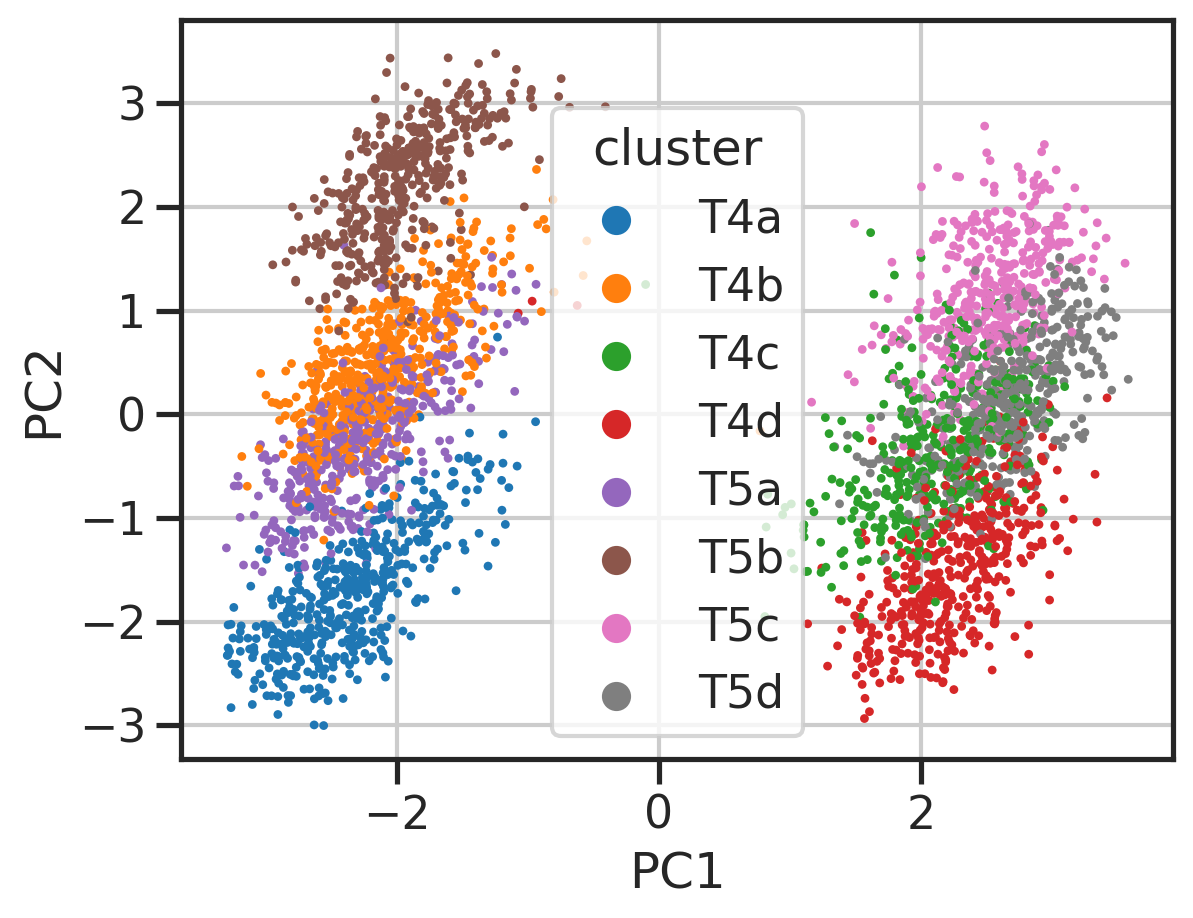

In [17]:
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster', s=10, edgecolor='none')#, palette=palette_type)

(-10.0, 10.0)

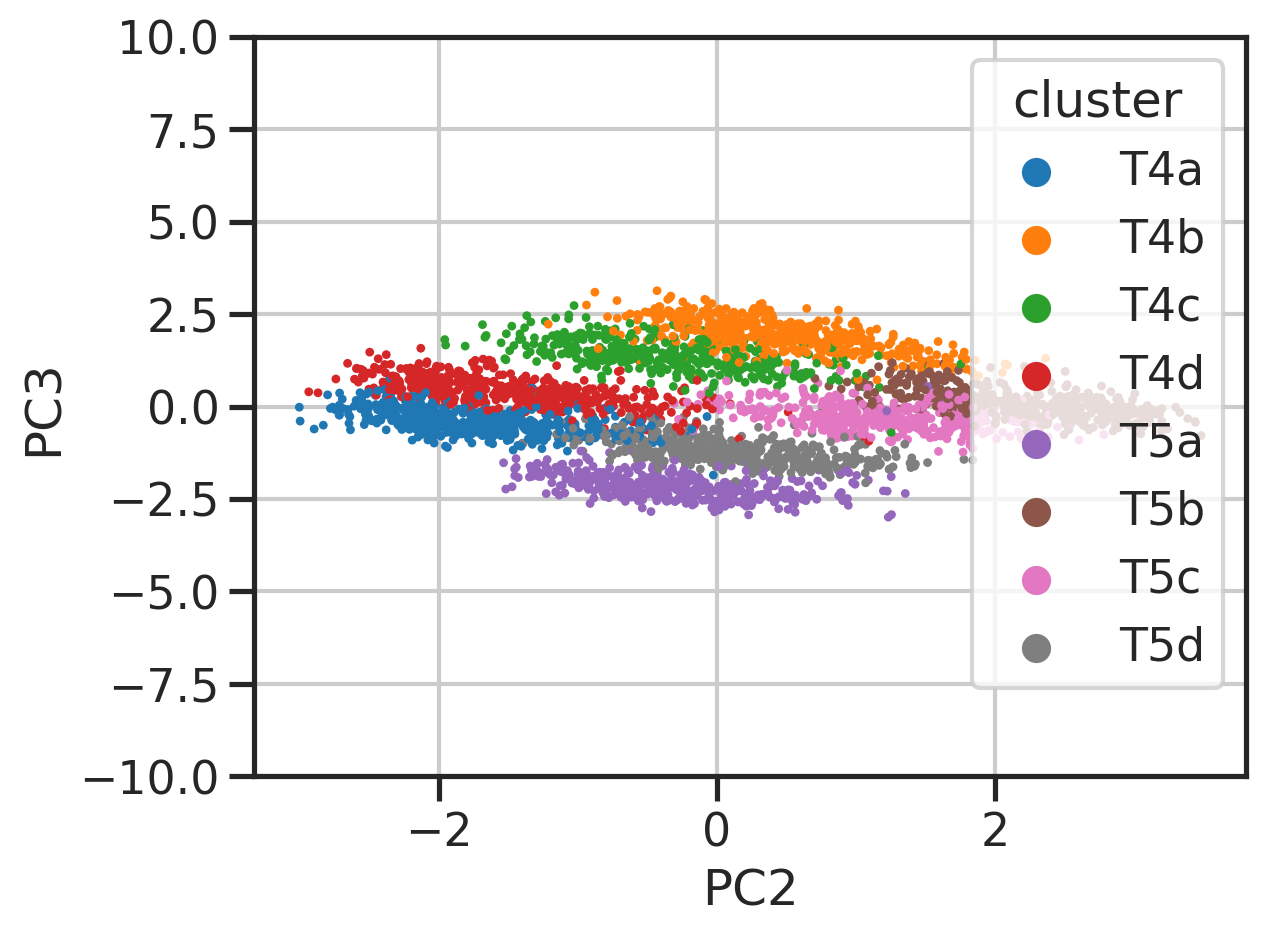

In [18]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x='PC2', y='PC3', hue='cluster', s=10, edgecolor='none')#, palette=palette_type)
ax.set_ylim([-10,10])
